In [1]:
import time
import threading

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg

import pandas as pd
import pandas_datareader.data as web

from sklearn import linear_model
import pandas as pd

In [2]:
d=2
M=150

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def vectorfieldSABR(state,increment):
    return np.array([(np.sqrt(state[0]**2))**0.7*np.exp(-0.5*state[1]),0.1])*increment[0]+np.array([0,0.25*(state[0]+state[1])])*increment[1]

def vectorfield2d(state,increment):
    return np.array([(2.0*np.sqrt(state[1]**2))**0.7+np.sin(state[1]),1.0*state[1]+np.cos(state[1])])*increment[0]+np.array([(2.0*np.sqrt(state[1]**2))**0.7,0.0*state[1]])*increment[1]

def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.03,size=(M,M))
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

In [3]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [4]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]

        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def reservoir(self,BMpath,scaling,k):
        reservoirpath = [canonical(k,self.dimensionR)*self.initialvalue] # e_k*X_0
        for i in range(self.timesteps):
            increment = scaling*(BMpath[i+1]-BMpath[i])
            reservoirpath = reservoirpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath

In [5]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

SDE_of_interest = SDE(7,1.0,2,d,M,vectorfield2d,3000)
training = SDE_of_interest.path()

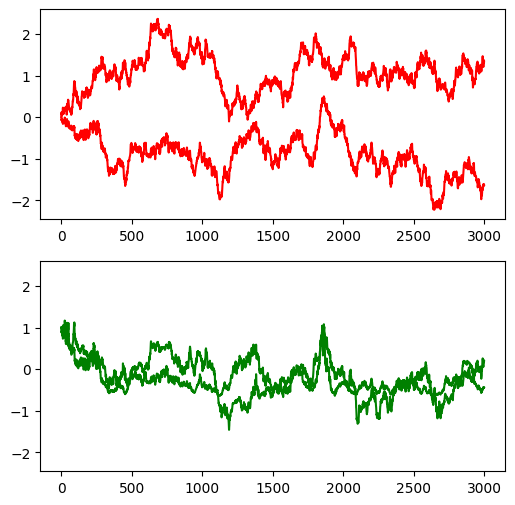

In [6]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0],'r')
p1[1].plot(training[1],'g')
plt.show()

In [7]:
Input=training[1]
Y = training[1]

Ydata = np.squeeze(Y)
Ytrain = Ydata[500:2500]

X=SDE_of_interest.reservoir(Input,1,0)

Xdata = np.squeeze(X) 
Xtrain = Xdata[:2000]

In [8]:
np.shape(Xtrain)
np.shape(Ytrain)

(2000, 2)

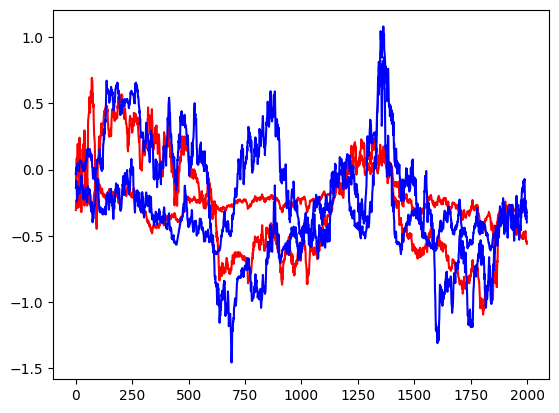

array([[ 8.41814545e-01, -1.27365967e+00,  8.41482450e-01,
        -1.65585981e+00,  6.06648201e-01,  3.50602346e-01,
         9.49648373e-01, -9.28501227e-02, -1.59228836e-03,
        -9.26440614e-01, -3.33971908e-01,  1.57894594e+00,
        -2.74121139e-01,  4.90201021e-01, -5.12321427e-01,
        -3.84157449e-01,  3.10610371e-02, -1.34369847e+00,
         3.86981513e-01,  2.98307772e-01,  8.54970883e-01,
        -1.66702868e+00, -5.61125664e-01, -2.23104490e-01,
         1.84366707e-02,  1.15005934e-01, -1.10030995e+00,
        -3.51225103e-01,  8.23448234e-02, -1.41467803e+00,
        -1.07456626e+00, -7.64464773e-01,  1.41009460e+00,
         2.90260587e-01, -2.71809527e-01,  1.14340584e+00,
         8.38591507e-01, -2.54345662e-01, -2.38230720e-01,
         1.15443934e+00, -1.22658066e+00,  3.57435805e-01,
         4.96065201e-01,  1.07502150e+00, -1.38811896e+00,
        -5.16982215e-01,  2.93477675e-02, -2.32704025e-01,
        -8.16705840e-01, -8.37964337e-01,  1.73023013e+0

In [9]:
from sklearn import linear_model
import pandas as pd
lm = linear_model.Ridge(alpha=0.05)#
model = lm.fit(Xtrain,Ytrain)
plt.plot(model.predict(Xtrain),'r')
plt.plot(Ytrain,'b')
plt.show()
model.score(Xtrain,Ytrain)
model.coef_

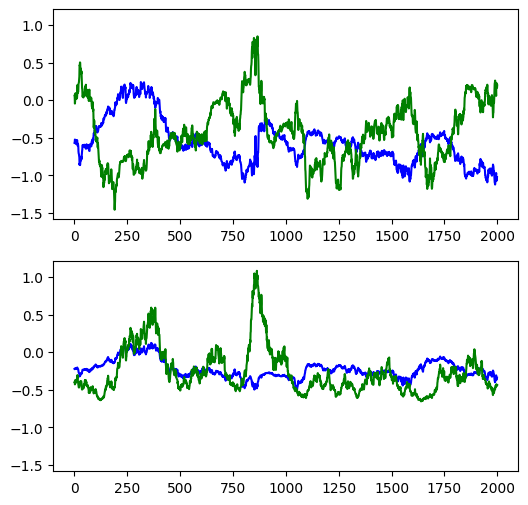

In [ ]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model.predict(Xdata[1000:])[:,i],'b')
    p[i].plot(Ydata[1000:][:,i],'g')
#plt.savefig('training.pdf')
plt.show()